# 01 Exploratory Data Analysis (EDA)

This notebook explores the dataset and saves artifacts (plots/tables) into `artifacts/`.

In [1]:
%run ./00_shared_utils.ipynb

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
set_seeds()

Shared utilities loaded. Use build_full_pipeline(classifier) to create a text model pipeline.


In [3]:
DATA_PATH = Path('data/Tweets.csv') 
assert DATA_PATH.exists(), f"Missing file: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

In [4]:
print(df.shape)
print(df.head())

(27481, 4)
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  


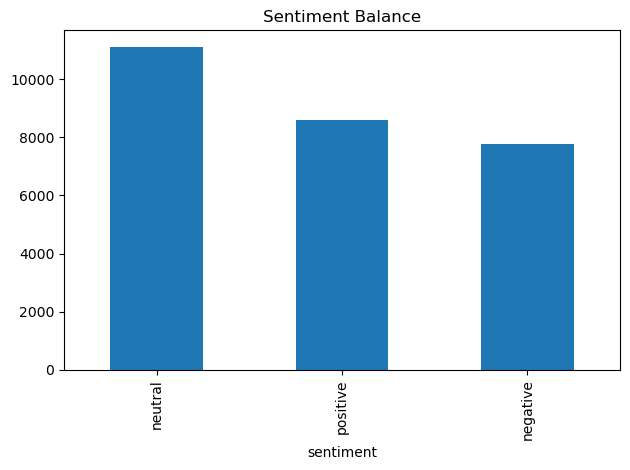

In [12]:
ax = df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Balance')
plt.tight_layout()
plt.savefig('artifacts/eda_sentiment_balance.png')
plt.show()

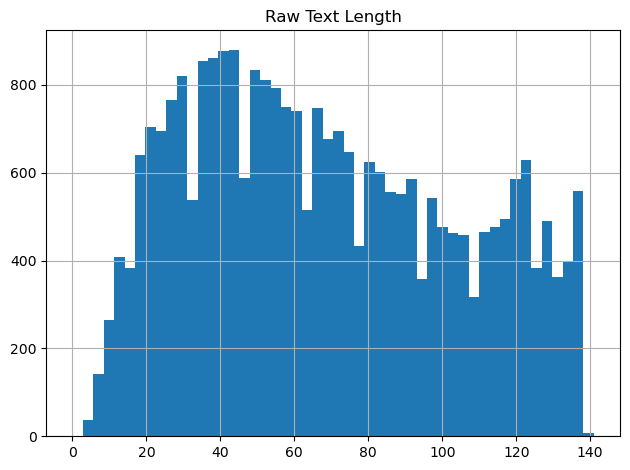

In [11]:
cleaned = CleaningTransformer().fit_transform(df[['text','selected_text']])
df['text_len_raw'] = df['text'].fillna('').str.len()
df['text_len_clean'] = cleaned['text_len']

plt.figure()
df['text_len_raw'].hist(bins=50)
plt.title('Raw Text Length')
plt.tight_layout()
plt.savefig('artifacts/eda_text_len_raw.png')
plt.show()

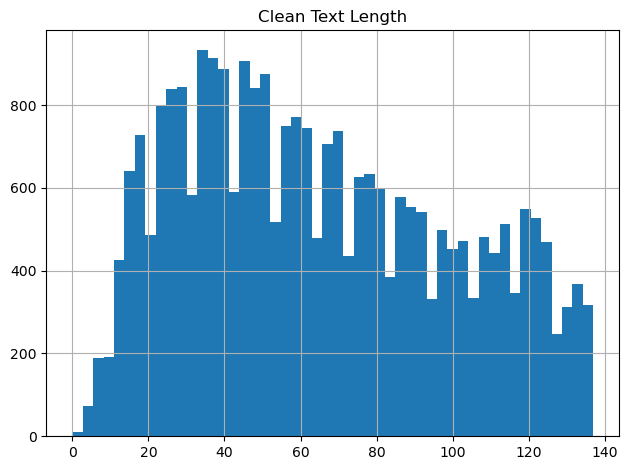

In [10]:
plt.figure()
df['text_len_clean'].hist(bins=50)
plt.title('Clean Text Length')
plt.tight_layout()
plt.savefig('artifacts/eda_text_len_clean.png')
plt.show()

In [ ]:
feature_cols = ['text_len', 'url_count', 'mention_count', 'hashtag_count', 'has_emoji', 'keyword_overlap']
feature_profile = cleaned[feature_cols].copy()
feature_profile['sentiment'] = df['sentiment']
feature_summary = feature_profile.groupby('sentiment')[feature_cols].agg(['mean', 'median']).round(2)
print(feature_summary)
feature_summary.to_csv('artifacts/eda_feature_summary.csv')


In [ ]:
corr = feature_profile[feature_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('artifacts/eda_feature_corr_heatmap.png')
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='sentiment', y='text_len_clean')
plt.title('Clean Text Length by Sentiment')
plt.tight_layout()
plt.savefig('artifacts/eda_text_len_boxplot.png')
plt.show()


In [ ]:
from collections import Counter
top_k = 10
top_terms = {}
for sentiment, texts in cleaned['text_clean'].groupby(df['sentiment']):
    counter = Counter()
    for txt in texts.dropna():
        counter.update(txt.split())
    records = counter.most_common(top_k)
    top_terms[sentiment] = [f"'{tok}' ({freq})" for tok, freq in records]
max_len = max(len(v) for v in top_terms.values()) if top_terms else 0
if max_len:
    for sent, values in top_terms.items():
        if len(values) < max_len:
            values.extend([''] * (max_len - len(values)))
    token_df = pd.DataFrame(top_terms)
    token_df.index = pd.Index(range(1, max_len + 1), name='rank')
    print(token_df)
    token_df.to_csv('artifacts/eda_top_tokens.csv')
else:
    print('No tokens available for summary.')


In [9]:
dup_by_id = df['textID'].duplicated().sum() if 'textID' in df.columns else 0
dup_by_text = df['text'].duplicated().sum()
na_counts = df.isna().sum()

summary = {
    'rows': int(df.shape[0]),
    'cols': int(df.shape[1]),
    'dup_by_id': int(dup_by_id),
    'dup_by_text': int(dup_by_text),
    'na_counts': na_counts.to_dict()
}
print(json.dumps(summary, indent=2))

with open('artifacts/eda_summary.json','w') as f:
    json.dump(summary, f, indent=2)

df.sample(20).to_csv('artifacts/eda_sample.csv', index=False)
print("EDA artifacts saved under artifacts/.")

{
  "rows": 27481,
  "cols": 6,
  "dup_by_id": 0,
  "dup_by_text": 0,
  "na_counts": {
    "textID": 0,
    "text": 1,
    "selected_text": 1,
    "sentiment": 0,
    "text_len_raw": 0,
    "text_len_clean": 0
  }
}
EDA artifacts saved under artifacts/.
